# Prerequisites
Make sure all these imports are working

In [1]:
import numpy as np
import seaborn
import torch
import torch.nn.functional as F
from matplotlib import pyplot
from torchvision import datasets, transforms
from tqdm.auto import tqdm
seaborn.set()  # pretty figures
device = 'cpu'  # set to 'cuda' if you have a GPU with CUDA

# MNIST

We're going to use the classic dataset "[MNIST](http://yann.lecun.com/exdb/mnist/)" to show-case how to build a deep-ish model in PyTorch.
A lot of the code for this tutorial is borrowed from the corresponding [PyTorch example](https://github.com/pytorch/examples/blob/master/mnist/main.py).

MNIST consists of 60,000 images of handwritten digits in 28x28 grayscale images with labels 0-9.
The advantage of such a small dataset is that we can quickly train it, even on CPU.
With a GPU, we could also train in minute(s) on the [CIFAR](https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py) dataset, and all the code of this tutorial would still apply.

PyTorch offers many [vision datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) in its `torchvision` package, which makes using the dataset extremely easy.

Data is typically further normalized to unit mean and variance. Practically, this leads to faster convergence because all the features are normalized to the same range.
<img src="ressources/normalization.jpeg" alt="normalization" title="image from https://cs231n.github.io/neural-networks-2/#datapre" width="500" />

In PyTorch, this normalization is done using [`transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) -- a convenience package that provides common image transformations which can be chained together.
In the following, we will build a transformation that first converts any incoming image into a tensor ([PyTorch's basic type](https://pytorch.org/docs/stable/tensors.html) of a multi-dimensional matrix) and then normalize it to MNIST's mean of 0.1307 and its standard deviation of 0.3081.

In [2]:
preprocessing = transforms.Compose([
                           transforms.ToTensor(),  # convert image to tensor -- the basic type that PyTorch operates on
                           transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean+std
                       ])
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=preprocessing)
mnist_test = datasets.MNIST('./data', train=False, transform=preprocessing)

Let's visualize some images from the dataset.

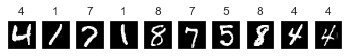

In [3]:
np.random.seed(0)
bunch_of_images = np.random.randint(len(mnist_train), size=10)
bunch_of_images = [mnist_train[i] for i in bunch_of_images]
fig, axes = pyplot.subplots(ncols=len(bunch_of_images))
for ax, (image_tensor, label) in zip(axes, bunch_of_images):
    ax.imshow(image_tensor.numpy().squeeze(), cmap='gray')
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])

To quickly load the MNIST images and iterate over it in batches, PyTorch provides [DataLoaders](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). A DataLoader provides an iterable over a dataset, and can use multiple workers to speed up image loading, randomly shuffle the data, and package it in batches.

In [4]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000, shuffle=True, num_workers=8)

# Creating a single-layer model

Starting simple, we'll first create a model with only a single layer.
We're using a linear layer which means that all of the layer's input nodes (in this case pixels) are connected to all of the layer's output nodes (in this case class predictions).
<img src="ressources/fully_connected.png" alt="fully-connected" title="image from https://www.oreilly.com/library/view/tensorflow-for-deep/9781491980446/ch04.html" width="200" />

In PyTorch, we can create a network class by inheriting from `torch.nn.Module`.
In the `__init__` function, we define the model's weight layer(s).
The `forward` function then implements how data flows through the network: in this case, incoming image batches `x` in the shape `batch x width x height` are first flattened into `batch x pixels`, then passed through our fully-connected layer, and finally these outputs are scaled to probabilities with a softmax so that all elements are ∈ [0, 1] and sum to 1.

In [5]:
class SingleLayer(torch.nn.Module):
    def __init__(self):
        super(SingleLayer, self).__init__()
        self.fc = torch.nn.Linear(28 * 28, 10)
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # flatten width x height, but not the batch
        x = self.fc(x)
        return F.softmax(x, dim=1)
    

# Training

Next, we'll train the network.
On top of the data and the network itself, we also need a way to compute the model deviation from target (the loss), and a way to update the weights from this discrepancy (loss + optimizer).

For the loss, we use the cross-entropy-loss, a standard for multi-class classification problems.
<img src="ressources/cross_entropy.png" alt="cross-entropy" title="image from https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss" width="300" />
In PyTorch, the loss fulfilles two tasks: 1) the deviation of prediction from target, and 2) the backward step to compute the relative contribution of each weight to the deviationm, i.e. the derivate of the weights with respect to the loss aka the gradients.

As optimizer, we use stochastic gradient descent (SGD) which simply updates weights in the opposite direction of the gradient.
Additionally, we will use momentum which intuitively speeds up the gradient steps when the gradient has been moving in one direction for a while.
<img src="ressources/sgd_momentum.png" alt="cross-entropy" title="image from https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/" width="300" />
For PyTorch's SGD implementation, we pass the model's parameters that it operates on, along with the learning rate α and momentum η.

In [6]:
def train(model, learning_rate=0.01, momentum=0.5):  # building up the train function
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # ...

Next, we will iterate over the data in batches -- one full iteration is called an epoch -- and run multiple epochs so that the model sees the data multiple times.

In [7]:
def train(num_epochs):
    # ...
    for epoch in range(num_epochs):
        for batch_inputs, batch_targets in data_loader:
            pass  # ...

For each batch, we do the following:

1. reset the gradients
2. run the model to obtain its predictions
3. compute the loss
4. compute the gradients
5. update the weights with the optimizer

In [8]:
def train():
    # ...
        # ...
            optimizer.zero_grad()  # 1
            predictions = model(batch_inputs)  # 2
            batch_loss = loss(predictions, batch_targets)  # 3
            batch_loss.backward()  # 4
            optimizer.step()  # 5

Putting it all together:

In [9]:
def train(model, data_loader, num_epochs=5, learning_rate=0.01, momentum=0.5, device='cpu'):
    model.train()  # set model into training mode: notify e.g. dropout/batchnorm layers
    # The loss is a differentiable scalar telling us how far off we are.
    # This function will also backward-compute the derivate of each weight w.r.t. the loss (i.e. the gradients)
    loss = torch.nn.CrossEntropyLoss()
    # The optimizer uses the computed gradients to update the weights
    # see e.g. https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944/2 for more details
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    losses = []
    step_progressbar = tqdm(total=num_epochs * len(data_loader.dataset), desc='training steps')
    for epoch in range(num_epochs):
        for batch_inputs, batch_targets in data_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            optimizer.zero_grad()  # reset gradients
            predictions = model(batch_inputs)
            batch_loss = loss(predictions, batch_targets)
            batch_loss.backward()  # backward step: compute gradients
            optimizer.step()  # optimizer step: apply gradients to parameters
            step_progressbar.update(len(batch_inputs))
            step_progressbar.set_postfix(loss=batch_loss.item(), epoch=epoch)
            losses.append(batch_loss.item())
    return losses

Finally, let's train our single-layer network.

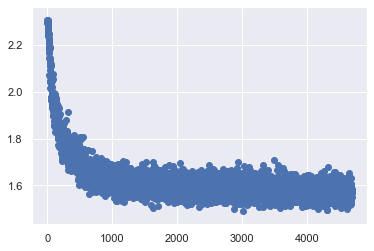

In [10]:
naive_net = SingleLayer()
naive_net = naive_net.to(device)
losses = train(naive_net, train_loader, device=device)
pyplot.scatter(x=list(range(len(losses))), y=losses)

Great, loss is going down, so the network is learning.

Let's see how well it's doing by evaluating its accuracy.

In [11]:
def test(model, data, device='cpu'):
    model.eval()
    correct = 0
    with torch.no_grad():  # no need to compute gradients
        for batch_inputs, batch_targets in data:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            softmax_output = model(batch_inputs)
            predictions = softmax_output.argmax(dim=1) # get the index of the max log-probability
            correct += (predictions == batch_targets).sum().item()
    return 100 * correct / len(data.dataset)
    

In [12]:
train_accuracy = test(naive_net, train_loader, device=device)
test_accuracy = test(naive_net, test_loader, device=device)
print(f"Train top-1: {train_accuracy:.2f}% | Test top-1: {test_accuracy:.2f}%")

Train top-1: 91.06% | Test top-1: 91.46%


Even our simple single-layer network achieves around 91% accuracy on the MNIST dataset after only a minute of training.

Keep in mind though that this is a simple dataset and that [state-of-the-art](https://paperswithcode.com/sota/image-classification-on-mnist) is around 99.8%.

# Multi-layer network
To get to near 100% accuracy, we need to improve our model.
We'll do so by using a deep-ish network of 2 convolutional layers followed by 2 fully-connected layers (if you don't know about convolutional layers, [Stanford's CS231n](https://cs231n.github.io/convolutional-networks/) has good explanations).
Each of the hidden layers will be followed by a [ReLU activation function](http://www.cs.toronto.edu/~fritz/absps/reluICML.pdf) and the convolutional layers are additionally followed by a max-pool operation to reduce the spatial size of the representation.

<img src="ressources/deepnet.png" alt="deepnet architecture" title="image modified from https://towardsdatascience.com/a-simple-2d-cnn-for-mnist-digit-recognition-a998dbc1e79a" width="300" />

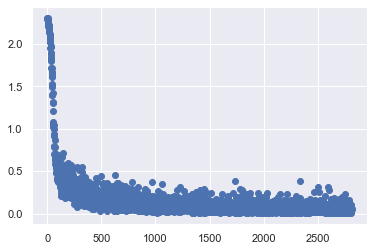

Train top-1: 98.45% | Test top-1: 98.43%


In [13]:
class DeepNet(torch.nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 5, 1)
        self.conv2 = torch.nn.Conv2d(20, 50, 5, 1)
        self.fc1 = torch.nn.Linear(4*4*50, 500)
        self.fc2 = torch.nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# train
deepnet = DeepNet()
deepnet = deepnet.to(device)
losses = train(deepnet, train_loader, num_epochs=3, device=device)
pyplot.scatter(x=list(range(len(losses))), y=losses)
pyplot.show()

# test
train_accuracy = test(deepnet, train_loader, device=device)
test_accuracy = test(deepnet, test_loader, device=device)
print(f"Train top-1: {train_accuracy:.2f}% | Test top-1: {test_accuracy:.2f}%")


The deep network gets us pretty close to state-of-the-art with around 99% correct.
Granted, MNIST is a toy dataset nowadays, but most of the techniques introduced until now carry over to larger datasets such as CIFAR or ImageNet.

Side note: I like PyTorch because the code is intuitive to write and involves minimal boiler-plate.
For an impression of what I mean, compare the definition of the network and training here with an equivalent tutorial in TensorFlow: https://github.com/tensorflow/models/blob/master/official/mnist/mnist.py

### quick training FAQ (following Andrew Ng's deep learning recipe)

* model can't fit the data? 
    
    -> bigger network
    
    -> train longer
    
    -> different architecture
    
* low accuracy on test data?

    -> more data
    
    -> more regularization
    
    -> different architecture

# weight & feature visualization

Finally, let's look at what the network has learned.

We can easily visualize the first-layer weights, because they just operate on the image itself and thus only have single-channel input (grayscale, or in RGB 3-channel).

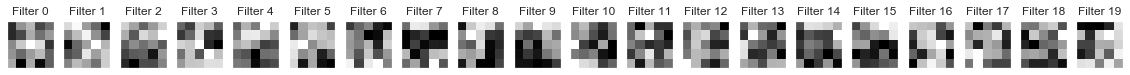

In [14]:
def visualize_conv(weights):
    fig, axes = pyplot.subplots(ncols=weights.shape[0], figsize=(20, 4))
    for ax, filter_num in zip(axes, range(weights.shape[0])):
        filter_weights = weights[filter_num].data.squeeze()
        ax.imshow(filter_weights, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Filter {filter_num}")

visualize_conv(deepnet.conv1.weight)

For networks trained on large-scale RGB image datasets, the first-level filters typically start looking like Gabors and color filters:
<img src="ressources/conv1.png" alt="conv1 filters (CORnet-S on ImageNet)" title="conv1 filters from training CORnet-S on ImageNet" width="300" />

We can also visualize the feature map.

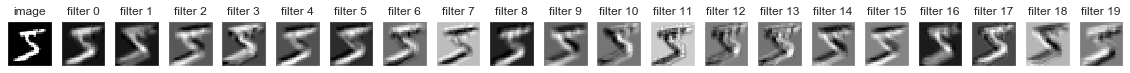

In [15]:
# from https://discuss.pytorch.org/t/visualize-feature-map/29597/2
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

deepnet.conv1.register_forward_hook(get_activation('conv1'))
image, _ = mnist_train[0]
image.unsqueeze_(0)
output = deepnet(image)

activations = activations['conv1'].squeeze()
fig, axes = pyplot.subplots(ncols=activations.shape[0] + 1, figsize=(20, 4))
axes[0].imshow(image.squeeze(), cmap='gray')
axes[0].set_title('image')
for filter_num, (ax, filter_activations) in enumerate(zip(axes[1:], activations)):
    ax.imshow(filter_activations, cmap='gray')
    ax.set_title(f'filter {filter_num}')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    

# Implementing custom models

You can easily implement custom activations functions, weight layers, loss functions and more.
As long as you operate on tensors, PyTorch's autograd package will take care of computing the gradients.

As an example, we can implement a [SeLU](http://papers.nips.cc/paper/6698-self-normalizing-neural-networks) activation function.
\begin{align}
\text{selu}(x) 
= \lambda \left\{
              \begin{array}{ll}
                  x & \text{if }x > 0\\
                  \alpha e^x - \alpha & \text{if }x \leq 0
              \end{array}
          \right.
= \lambda \times (max(0, x) + min(0, \alpha e^x - \alpha))
\end{align}

Test top-1: 91.53%


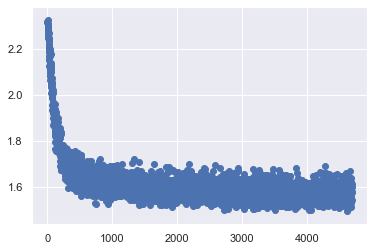

In [16]:
from math import e

class SeLU(torch.nn.Module):
    def __init__(self, alpha=1.6732632423543772848170429916717, scale=1.0507009873554804934193349852946):
        super(SeLU, self).__init__()
        self._alpha = alpha
        self._scale = scale
        
    def forward(self, x):
        zero = torch.zeros_like(x)
        return self._scale * (torch.max(zero, x) + torch.min(zero, self._alpha * (e ** x) - self._alpha))
        # or even simpler: return self._scale * F.elu(x, self._alpha)

class SeLUNet(torch.nn.Module):
    def __init__(self):
        super(SeLUNet, self).__init__()
        self.fc = torch.nn.Linear(28 * 28, 10)
        self.selu = SeLU()
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = self.selu(x)
        return F.softmax(x, dim=1)
    
selu_net = SeLUNet()
selu_net = selu_net.to(device)
losses = train(selu_net, train_loader, device=device)
pyplot.scatter(x=list(range(len(losses))), y=losses)

test_accuracy = test(selu_net, test_loader, device=device)
print(f"Test top-1: {test_accuracy:.2f}%")

Or, we could implement a custom loss function. As an example, we'll implement an L1-norm sparseness constraint on the weight activations.

Test top-1: 9.12%


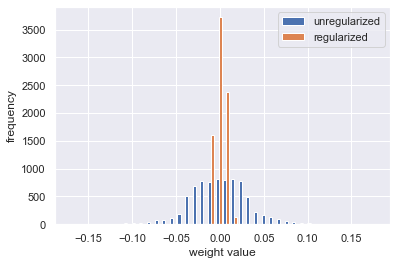

In [17]:
def l1_norm(model):  # pytorch has a built-in for this too, we could just use torch.nn.L1Loss
    norm = 0
    for param in model.parameters():
        norm += torch.sum(torch.abs(param))
    return norm


def regularized_train(model, data_loader, num_epochs=5, learning_rate=0.01, momentum=0.5, device='cpu'):
    model.train()
    categorization_loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    losses = []
    step_progressbar = tqdm(total=num_epochs * len(data_loader.dataset), desc='training steps (regularization)')
    for epoch in range(num_epochs):
        for batch_inputs, batch_targets in data_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            optimizer.zero_grad()  # reset gradients
            predictions = model(batch_inputs)
            batch_categorization_loss = categorization_loss(predictions, batch_targets)
            regularization_loss = l1_norm(model)
            batch_loss = batch_categorization_loss + regularization_loss
            batch_loss.backward()  # backward step: compute gradients
            optimizer.step()  # optimizer step: apply gradients to parameters
            step_progressbar.update(len(batch_inputs))
            step_progressbar.set_postfix(loss=batch_loss.item(), epoch=epoch)
            losses.append(batch_loss.item())
    return losses


unregularized_selu_net = SeLUNet()
regularized_selu_net = SeLUNet()
train(unregularized_selu_net, train_loader, num_epochs=1, device=device)
regularized_train(regularized_selu_net, train_loader, num_epochs=1, device=device)

test_accuracy = test(regularized_selu_net, test_loader, device=device)
print(f"Test top-1: {test_accuracy:.2f}%")
   
unregularized_weights = unregularized_selu_net.fc.weight.detach().numpy().reshape(-1)
regularized_weights = regularized_selu_net.fc.weight.detach().numpy().reshape(-1)
pyplot.hist([unregularized_weights, regularized_weights], bins=40, label=['unregularized', 'regularized'])
pyplot.xlabel('weight value')
pyplot.ylabel('frequency')
pyplot.legend()

# Beyond this tutorial

Obviously, image classification is just a small part of the PyTorch ecosystem.
In vision, you might be interested in [super resolution](https://github.com/pytorch/examples/blob/master/super_resolution), [GANs](https://github.com/pytorch/examples/blob/master/dcgan) or [semantic segmentation](https://github.com/CSAILVision/semantic-segmentation-pytorch).
In Natural Language Processing (NLP), we can [predict next words](https://github.com/pytorch/examples/tree/master/snli), or [translate between languages](https://github.com/OpenNMT/OpenNMT-py).
There are more examples around [Reinforcement Learning (RL)](https://github.com/pytorch/examples/tree/master/reinforcement_learning) and many more.